Link to website: https://danellsworth.github.io/

## Milestone 1 - Financial Sentiment Analysis

Dan Ellsworth and Alden Pratt

> For our Final Tutorial Project, we will be examining the effectiveness of using sentiment analysis based on Twitter posts relating to publicly traded companies as a leading or lagging indicator of the stock price.  Fluctuations in stock prices can be largely attributed to changes in the attitude of its buyers and holders. As such, platforms in which people are allowed to freely voice their attitude toward a company, such as Twitter, can be influential for a broad audience of traders.  If a particular authority voices optimism regarding the future of a company’s stock, and enough people are convinced into buying, its stock price will increase to meet the increased demand.  Conversely, authority figures voicing pessimism generally results in a lower price.  We will be using company sentiment data from Twitter to see if there is a significant correlation between community sentiment and the change in the stock price. 
> Through studying this issue, several questions arise.  We are curious to know if sentiment generally follows stock prices or if stock prices follow sentiment. In other words, should we be looking at sentiment as a leading or lagging indicator of stock prices?  Who is influential?  Are some companies intrinsically more or less resistant to changes in sentiment?  Can our findings be used in developing a complete and profitable trading strategy?  
    
Below are a couple of data sets containing sentiment analysis for various companies:
   >  https://www.kaggle.com/vivekrathi055/sentiment-analysis-on-financial-tweets 
   >  https://www.kaggle.com/yash612/stockmarket-sentiment-dataset
    
> To determine the effects that Twitter posts have on stock prices, we plan on combining one of these data sets with historical stock price data that can be pulled from Yahoo Finance.  Yahoo Finance provides data for stock price fluctuations for every company and every day.  We expect that the changes in public sentiment over time will somewhat mirror the changes in the stock price as provided by Yahoo Finance.    



## Collaboration Plan

> We have and will continue to meet via Zoom biweekly, and possibly more frequently as needed to satisfy approaching deadlines. We acknowledge that this will likely change depending on what phase of the project we are in.

### Technologies:
- Github to coordinate code
- Shared Google Docs for write ups
- Twitter API
- RapidAPI (For Yahoo Finance data)







### Setup up and import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import itertools
import yfinance as yf
import quandl
import re
%matplotlib inline
from matplotlib import style

C:\Users\Danel\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#### Machine Learning and NLP imports

In [2]:
# nltk
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from yellowbrick.style import rcmod
rcmod.set_aesthetic(palette='yellowbrick', font='sans-serif', font_scale=1, color_codes=True, rc=None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Danel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Table of Contents

> #### S1: Apple Tweet Analysis
>[1.1 Extracting Data](#ExtractingAppleData) <br>
>[1.2 Natural Language Processing (NLP)](#NLP) <br>
>[1.3 Text Analysis for Training Data](#TrainingTxt) <br>
>[1.4 Testing Accuracy of Model](#TestAaplModel) <br>
> - [1.4a ROCAUC Curves](#AaplRoc) <br>
> - [1.4b Visualizing the Classification Model (F-Score)](#AaplClassVis) <br>
> - [1.4c Visualizing the Classification Report](#AaplClassReport) <br> 

>[1.5 Predicting Unseen Data](#AaplPredictUnseen) <br>
>[1.6 Text Analysis for Predicted Labels](#UnseenTxt) <br>

<br>

> #### S2: Gauging Airline Sentiment 
>[2.1 Extracting Data](#ExtractingAirlineData) <br>
>[2.2 Text Analysis for Training Data](#TrainingTxtAirline) <br>
>[2.3 Testing Accuracy of Model](#TestAirlineModel) <br>
> - [2.3a ROCAUC Curves](#AirlineRoc) <br>
> - [2.3b Visualizing the Classification Model (F-Score)](#AirlineClassVis) <br>
> - [2.3c Visualizing the Classification Report](#AirlineClassReport) <br> 

>[2.4 Predicting Unseen Data](#AirlinePredictUnseen) <br>
>[2.5 Text Analysis for Predicted Labels](#UnseenTxtAirline) <br>

<br>

> #### S3: Broad Market Sentiment Analysis
>[3.1 Extracting Data](#ExtractingMarket) <br>
>[3.2 Tidying Data](#TidyingMarket) <br>
>[3.3 Scraping Additional Data](#ScrapingMarket) <br>
>[3.4 Exploratory Data Analysis](#ExploratoryMarket) <br>
> - [3.4a Gauging Sector Sentiment](#SectorMarket) <br>
> - [3.4b Correlation](#CorrelationMarket) <br>
> - [3.4c Bitcoin vs. S&P500](#BTCMarket) <br> 

>[3.5 Final Thoughts](#FinalThoughtsMarket) <br>



<a id='ExtractingAppleData'></a>
### Extracting Apple Data

In [3]:
# read in apple sentiment training data
AppleDF = pd.read_csv('Apple-Tweet-Sentiment.csv', encoding="ISO-8859-1")

# import scraped airline Twitter data
Unseen_tweets = pd.read_csv('Apple_Scraped_Tweets.csv')

AppleDF.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/2014 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


<a id='NLP'></a>
## Natural Language Proccessing (NLP)
> explain the goal of this section

### Preprocessing the Training and Testing Data
> To increase the effectivness of our NLP learning algorthim, it is important to clean the tweets before using them for analysis. The preprocessing step eliminates the following:
-  stopwords (i.e. 'the', 'a', 'and', 'how', etc.)
- any tweet with a question mark - questions are not good indicators of sentiment 
- any non-letter (including: numbers, emojis, and punctuation) 
- URL links
- accounts refrenced using '@' symbol
- any words less than 3 characters
- Any Retweets - we decided not to count the same tweet twice


In [4]:
# create a class that cleans a list of tweets
class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])
    
    def processTrainingTweets(self, list_of_tweets):
        processedTweets = []
        for index, tweet in list_of_tweets.iterrows():
            processedTweets.append((self._process_training_tweet(tweet['text']), tweet['sentiment']) ) # posibly add confidence here 
        return processedTweets
    
    def processTweets(self, list_of_tweets):
        processedTweets = []
        for index, tweet in list_of_tweets.iterrows():
            processedTweets.append((self._process_tweet(tweet['text']), tweet['sentiment']) ) # posibly add confidence here 
        return processedTweets
    
    def _process_training_tweet(self, tweet):
        tweet = tweet.lower() # convert all letters to lowercase
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # removes URL's
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # removes usernames
        tweet = re.sub(r'[^\w\s]', '', tweet) # removes all non alphanumeric or non whitespace
        tweet = re.sub(r'[\d]', '', tweet) # removes all digits
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # removes any word smaller than 3
        tweet = re.sub(r'\s{2,}', ' ', tweet) # eliminates any spaces greater than 1
        tweet = word_tokenize(tweet) # removes repeated characters (i.e. hellllllo to hello)
        tweet_without_sw = [word for word in tweet if word not in self._stopwords]
        filtered_tweet = (" ").join(tweet_without_sw)
        return filtered_tweet

    def _process_tweet(self, tweet):
        if (re.search(r'[?]', tweet)):  # Questions do not tell us sentiment, let's get rid of them
            return np.nan
        if (re.search(r'RT', tweet)):  # if it is a retweet, delete it (we don't want to count the same tweet many times)
            return np.nan
        tweet = tweet.lower() # convert all letters to lowercase
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # removes URL's
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # removes usernames
        tweet = re.sub(r'[^\w\s]', '', tweet) # removes all non alphanumeric or non whitespace
        tweet = re.sub(r'[\d]', '', tweet) # removes all digits
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # removes any word smaller than 3
        tweet = re.sub(r'\s{2,}', ' ', tweet) # eliminates any spaces greater than 1
        tweet = word_tokenize(tweet) # removes repeated characters (i.e. hellllllo to hello)
        tweet_without_sw = [word for word in tweet if word not in self._stopwords]
        filtered_tweet = (" ").join(tweet_without_sw)
        return filtered_tweet

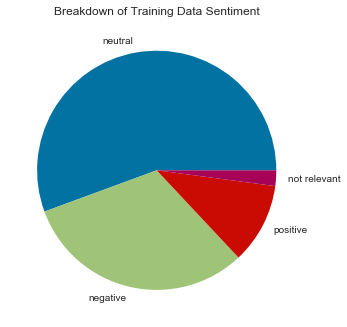

In [5]:
#style.use('seaborn-pastel') # change background for graph labels


# Print plot of sentiment contained in pie chart 
plt.pie(AppleDF.sentiment.value_counts(), labels = ['neutral','negative','positive', 'not relevant']) #, colors = {"3": "grey", "1": "Red", "5": "g"})
plt.title('Breakdown of Training Data Sentiment')
plt.show()

# omit the instances where the tweet is not relevant
AppleDF = AppleDF[AppleDF.sentiment != 'not_relevant']

# grab the columns we care about for training
applelist = AppleDF[['text', 'sentiment']]


tweetProcessor = PreProcessTweets()
preprocessedTrainingSet = tweetProcessor.processTrainingTweets(applelist) # preprocess training data

# revert back to DF
Processed_Tweet_Training = pd.DataFrame((preprocessedTrainingSet), columns =['tweet', 'sentiment'])

Processed_Tweet_Training.dropna(inplace = True) # drop any NA values (tweets that had question marks)


<a id='TrainingTxt'></a>
## Text Analysis For Training Data

In [6]:
def word_frequency_graph(ProcessedTweetsDF):
    
    positive_text = []
    neutral_text = []
    negative_text = []

    # seperate positive, negative, and neutral tweet text
    for i, row in ProcessedTweetsDF.iterrows():
        if row[1] in ['5', 'positive']:
            positive_text.append(row[0])
        elif row[1] in ['1', 'negative']:
            negative_text.append(row[0])
        else:
            neutral_text.append(row[0])

    # create figure and axes
    fig, axs = plt.subplots(1,3, figsize=(20,15))

    # calculate most frequent positive word tokens
    vectorizer = CountVectorizer()
    doc_pos = vectorizer.fit_transform(positive_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'g', ax=axs[0])
    visualizer.fit(doc_pos)
    axs[0].set_title('Fequency Distribution of Positive Word Tokens')

    # calculate most frequent negative word tokens
    doc_neg = vectorizer.fit_transform(negative_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'r', ax=axs[1])
    visualizer.fit(doc_neg)
    axs[1].set_title('Fequency Distribution of Negative Word Tokens')

    # calculate most frequent neutral word tokens
    vectorizer = CountVectorizer()
    doc_neut = vectorizer.fit_transform(neutral_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'gray', ax=axs[2])
    visualizer.fit(doc_neut)

    visualizer.show();  # plot figure

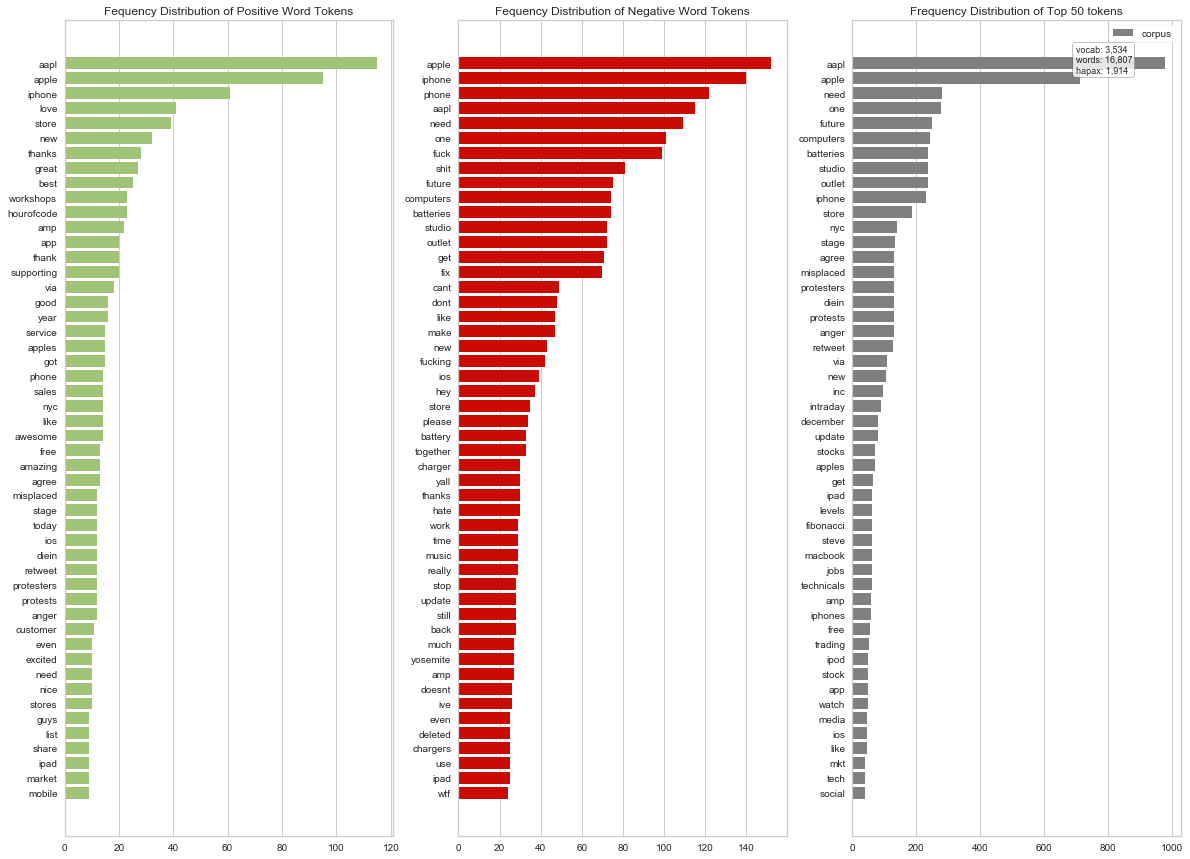

In [7]:
word_frequency_graph(Processed_Tweet_Training)

<a id='TestAaplModel'></a>
## Testing the Accuracy

<a id='AaplRoc'></a>
### ROCAUC Curves

A ROCAUC (Receiver Operating Characteristic/Area Under the Curve) plot allows the user to visualize the tradeoff between the classifier’s sensitivity and specificity.

The Receiver Operating Characteristic (ROC) is a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the model’s sensitivity and specificity. 

This leads to another metric, area under the curve (AUC), which is a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is.

In [8]:
def ROC_Curve(Processed_Tweet_Training):  
    # create dummy variables - i.e. tokenize words and label 1 or 0 
    mlb = MultiLabelBinarizer()
    X = pd.DataFrame(mlb.fit_transform([x.split(' ') for x in Processed_Tweet_Training['tweet']]),columns=mlb.classes_)

    # transform sentiment into labels matching tokenized word DF
    y = LabelEncoder().fit_transform(Processed_Tweet_Training['sentiment'])

    # Create the train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # create figure and axes
    fig, ax = plt.subplots(figsize=(10,7.5))
    
    # Instaniate the classification model and visualizer
    model = MultinomialNB()
    visualizer = ROCAUC(model, classes=["Negative Sentiment", "Neutral Sentiment", "Positive Sentiment"], ax = ax)
    

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show();               # Finalize and render the figure

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


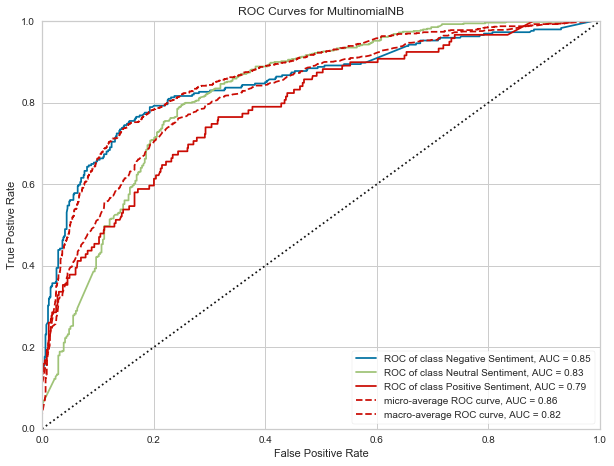

In [9]:
# Call Receiver Operating Characteristic Function
ROC_Curve(Processed_Tweet_Training)

<a id='AaplClassVis'></a>
### Visualizing the Classification Model (F-Score)

we show how to visualize the learning curve of a classification model.
reasons we choose the MultinomialNB Classifier is we did not have that much data and NB converges quickly

In [10]:
def Visualize_Classification_Model(Processed_Tweet_Training):   
    
    mlb = MultiLabelBinarizer()
    X = pd.DataFrame(mlb.fit_transform([x.split(' ') for x in Processed_Tweet_Training['tweet']]),columns=mlb.classes_)

    # transform sentiment into labels matching tokenized word DF
    y = LabelEncoder().fit_transform(Processed_Tweet_Training['sentiment'])
    
    # Create the learning curve visualizer
    cv = StratifiedKFold(n_splits=12)
    sizes = np.linspace(0.3, 1.0, 10)
    
     # create figure and axes
    fig, ax = plt.subplots(figsize=(10,7.5))
    
    # Instantiate the classification model and visualizer
    model = MultinomialNB()
    visualizer = LearningCurve(
        model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, ax = ax
    )

    visualizer.fit(X, y)        # Fit the data to the visualizer
    visualizer.show();           # Finalize and render the figure

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


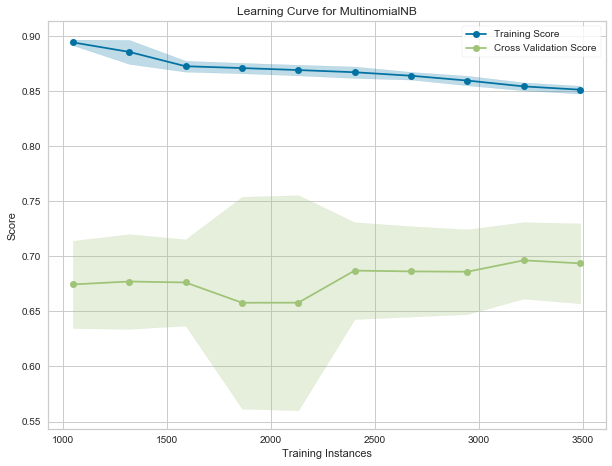

In [11]:
# create visualization of model - this might take a min to run
Visualize_Classification_Model(Processed_Tweet_Training)

In [12]:
# create tokenize column
Processed_Tweet_Training['tokenized_tweets'] = Processed_Tweet_Training.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)


<a id='AaplClassReport'></a>
### Classification Report

In [13]:
X = Processed_Tweet_Training['tweet'] 
y = Processed_Tweet_Training["sentiment"]

# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

confusion_matrix(y_test, y_pred)

# print classification report - where 1 is negative, 3 is neutral, and 5 positive
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           1       0.66      0.73      0.69       413
           3       0.80      0.77      0.79       716
           5       0.49      0.43      0.46       127

    accuracy                           0.72      1256
   macro avg       0.65      0.64      0.64      1256
weighted avg       0.72      0.72      0.72      1256



In [14]:
# training on the entire dataset

# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X,y)
y_pred = pipeline.predict(X_test)

<a id='AaplPredictUnseen'></a>
## Predicting Classification of Unseen Data

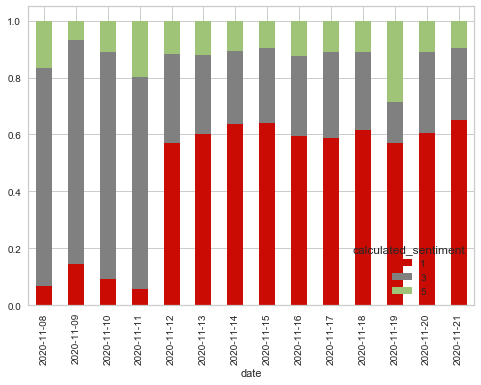

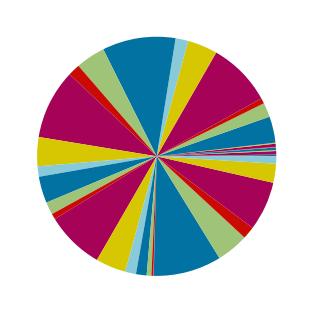

In [15]:
# predicting unseen data

# format data for preprocessing 
Unseen_tweets_text = Unseen_tweets[['text', 'sentiment']]

Preprocessed_Data = tweetProcessor.processTweets(Unseen_tweets_text) # preprocess test data
Processed_Tweets = pd.DataFrame((Preprocessed_Data), columns =['tweet', 'sentiment'])

Apple_Data = Unseen_tweets[Processed_Tweets['tweet'].notnull()] # get rid of omited rows in original DF
Apple_Data.reset_index(inplace = True) # permanently reset the index to account for dropped values

Processed_Tweets.dropna(inplace = True) # drop any NAN rows (tweets with question marks)
y = Processed_Tweets["tweet"] 

y_pred = pipeline.predict(y)

Results = pd.DataFrame(list(zip(Processed_Tweets.tweet, y_pred)),
  columns=['tweet','calculated_sentiment'])


#Results = Results.sort_values(by = 'calculated sentiment')
Results.to_csv("First Try2.csv")

# inner join the two DF's on the index column - which coresponds to the same observation
AppleResultsDF = Results.merge(Apple_Data, how='inner', left_index = True, right_index = True)


AppleResultsDF['date'] = pd.to_datetime(AppleResultsDF['date'])

sentiment_day_counts = pd.crosstab(AppleResultsDF['date'].dt.date, AppleResultsDF.calculated_sentiment)
(sentiment_day_counts.divide(
    sentiment_day_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True, color = ['r', 'grey', 'g'])
plt.show()
#sentiment_given_day = 

plt.pie(AppleResultsDF.groupby(AppleResultsDF['date'].dt.date).calculated_sentiment.value_counts())


#plt.pie(Results['calculated_sentiment'].value_counts(), labels = ['neutral','negative','positive'])
plt.plot();

<a id='UnseenTxt'></a>

### Text Analysis for Predicted Labels

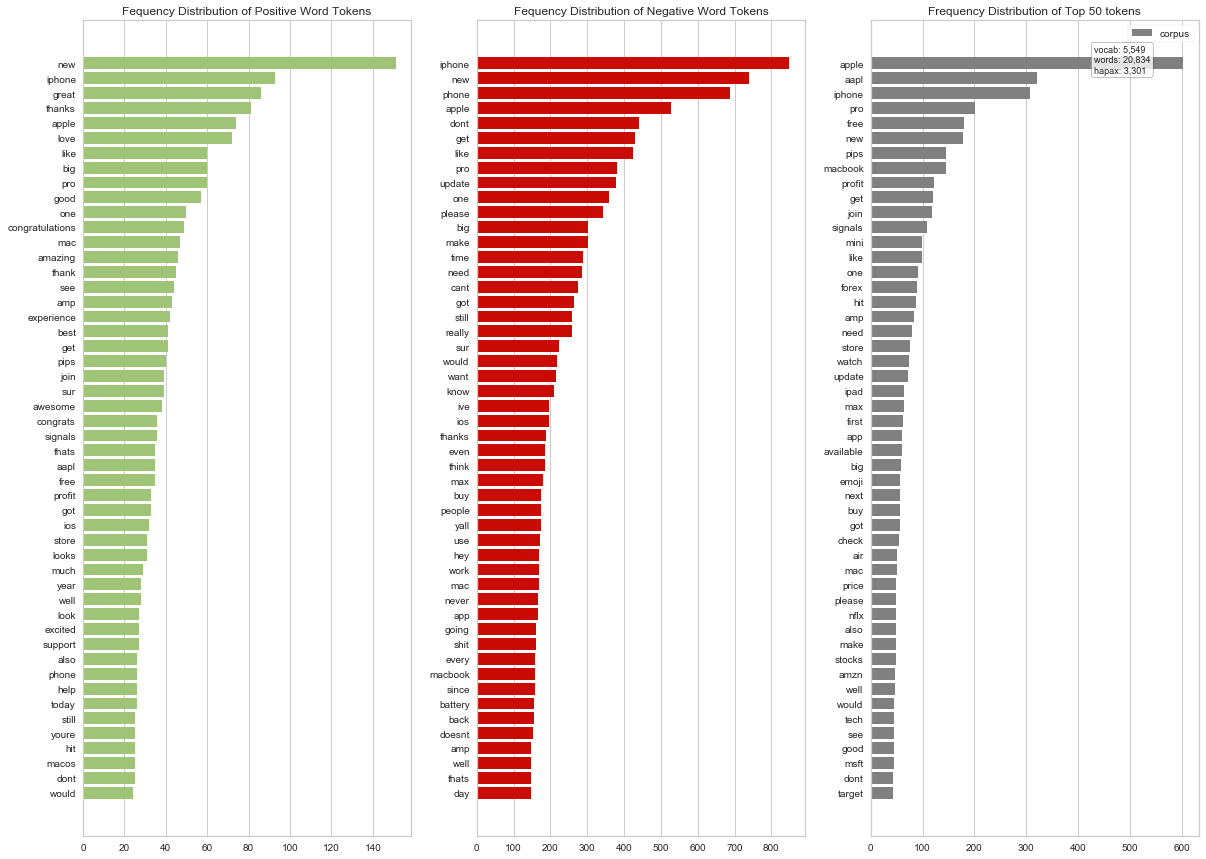

In [16]:
# Word Frequency analysis on the predicted labels
word_frequency_graph(AppleResultsDF[['tweet','calculated_sentiment']])

### Preliminary Thoughts
> While the NLP classification appears to be relativley accurate (80%), it is difficult to draw any meaningful conclusions in regaurds to where Apple stock might be headed. It is clear, that more people are heading to Twitter to complain about an Apple product than praise it; however, this does not necessarily mean Apple stock is in trouble. We can consider a few things:
-  People have an incentive to complain when a product is malfunctioning but little incentive to praise a product when it works how we expect it to (Many negativley classified tweets reference the Big Sur update - we expect an update to work, but when it doesn't, an angry tweet storm ensues)

## Section 2: Gauging Airline Sentiment Using NLP
Let's try this with a variety of Airline tweets. Again, we will see more people tweet about a negative flight expirences than a good ones, but would we rather own the airline with the fewest or most complaints? 

<a id='ExtractingAirlineData'></a>
### Extracting Airline Data

In [17]:
# import testing data
Training_tweets = pd.read_csv('Twitter_Airline_Sentiment_Labeled.csv')

# use heatmap to show sentiment
Training_tweets.rename(columns = {'airline_sentiment': 'sentiment'}, inplace = True)

# filter dataframe to only include 'text' and 'sentiment' columns
Train_tweets_text = Training_tweets[['text', 'sentiment']]

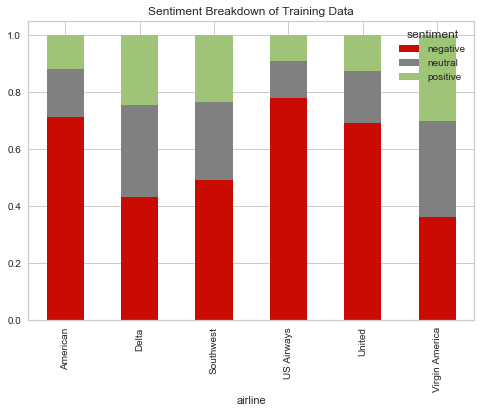

In [18]:
# import testing data
Testing_tweets = pd.read_csv('Twitter_Airline_Sentiment_Labeled.csv')

# print graph of the training set - how each airline breaks down
sentiment_airline_counts = pd.crosstab(Training_tweets['airline'], Training_tweets.sentiment)
(sentiment_airline_counts.divide(
    sentiment_airline_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True, color = ['r', 'grey', 'g'])
plt.title("Sentiment Breakdown of Training Data")
plt.show();


tweetProcessor = PreProcessTweets()
preprocessedTrainingSet = tweetProcessor.processTrainingTweets(Train_tweets_text) # preprocess training data

Processed_Tweet_Training = pd.DataFrame((preprocessedTrainingSet), columns =['tweet', 'sentiment'])
Processed_Tweet_Training.dropna(inplace = True) # drop any NA values (tweets that had question marks)

<a id='TrainingTxtAirline'></a>
### Text Analysis of Training Set

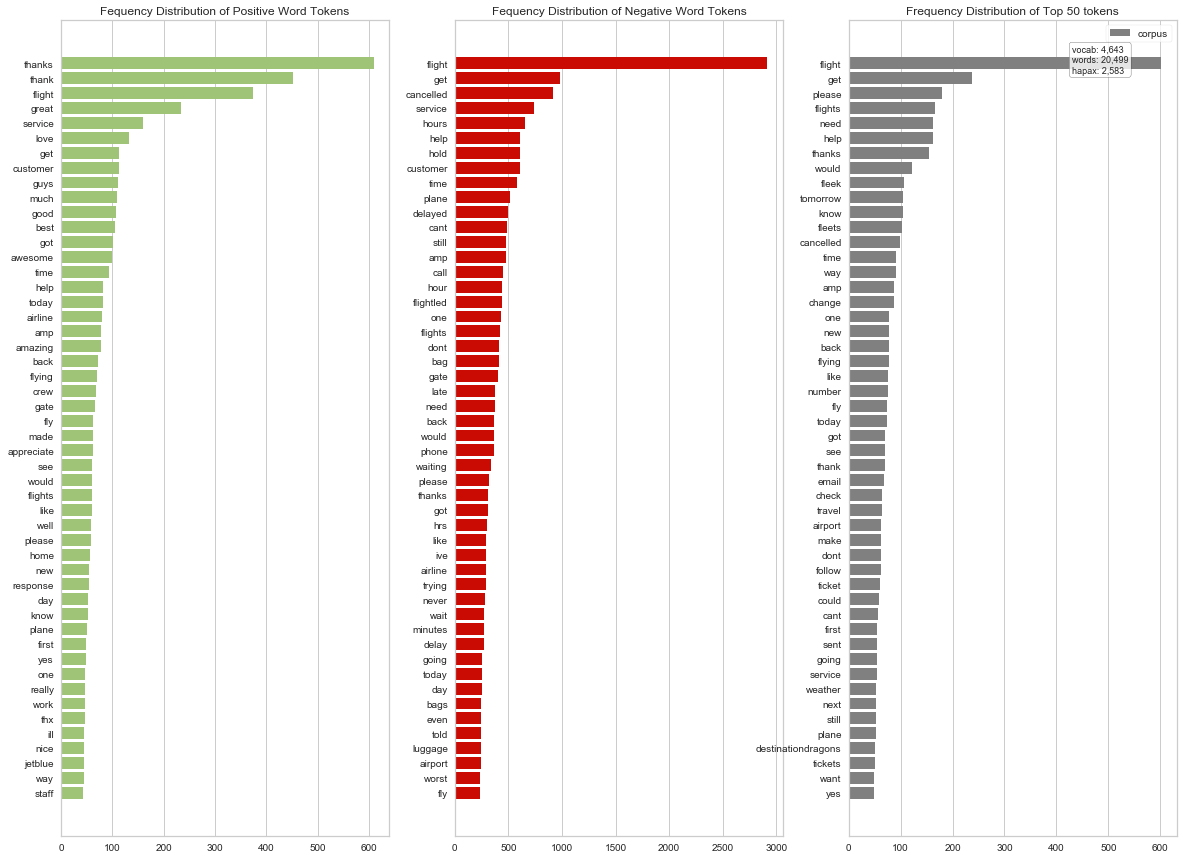

In [19]:
word_frequency_graph(Processed_Tweet_Training)

<a id='TestAirlineModel'></a>
## Testing the Accuracy

<a id='AirlineRoc'></a>
### ROCAUC Curves

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


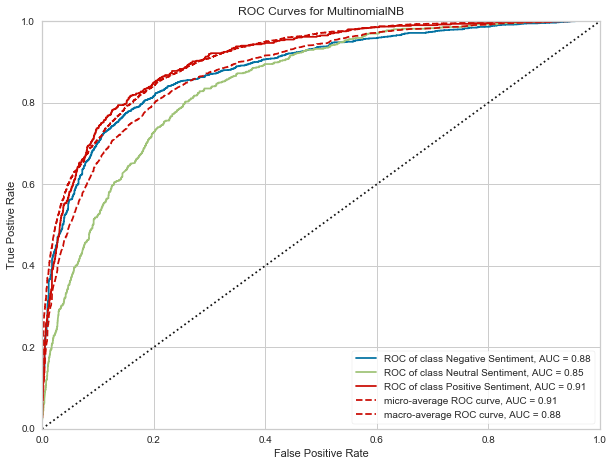

In [20]:
# Call Receiver Operating Characteristic Function
ROC_Curve(Processed_Tweet_Training)

<a id='AirlineClassVis'></a>
### Visualizing the Classification Model (F-Score)


C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


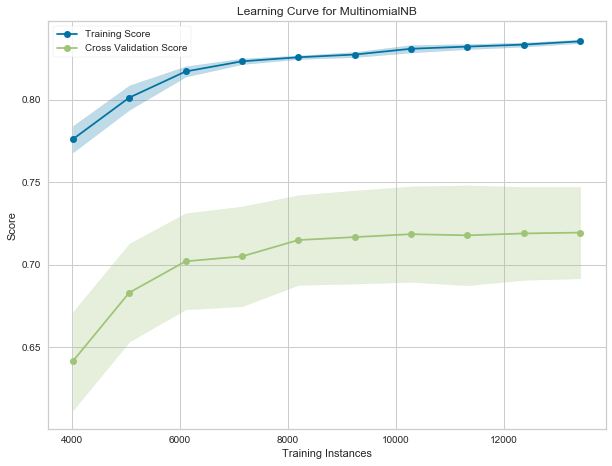

In [21]:
Visualize_Classification_Model(Processed_Tweet_Training)

<a id='AirlineClassReport'></a>
### Classification Report

In [22]:
# define X as the tweets and y as the labels 
X = Processed_Tweet_Training['tweet'] 
y = Processed_Tweet_Training["sentiment"]

# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(5,5))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

# print classification report - determines the accuracy of model
print(classification_report(y_test,y_pred))

# zip the calculated results together with the actual results
Results = pd.DataFrame(list(zip(y_test, y_pred)),
  columns=['actual sentiment','calculated sentiment'])

              precision    recall  f1-score   support

    negative       0.78      0.94      0.85      3021
     neutral       0.68      0.37      0.48      1059
    positive       0.69      0.57      0.62       752

    accuracy                           0.76      4832
   macro avg       0.72      0.63      0.65      4832
weighted avg       0.74      0.76      0.74      4832



In [23]:
# retraining using all the data 
# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X,y);

<a id='AirlinePredictUnseen'></a>
### Predicting Unseen Data

In [24]:
# import unseen airline tweet data (saved on local storage)
Airline_Data = pd.read_csv('Airline_Scrapped_Tweets.csv')
Airline_Tweets = Airline_Data[['text', 'sentiment']]

tweetProcessor = PreProcessTweets()
Preprocessed_Airline_Tweets = tweetProcessor.processTweets(Airline_Tweets) # preprocess training data

# format the cleaned tweets (proccesed) into a new DF
Processed_Tweets = pd.DataFrame((Preprocessed_Airline_Tweets), columns =['tweet', 'sentiment'])

Airline_Data = Airline_Data[Processed_Tweets['tweet'].notnull()] # get rid of omited rows in original DF
Airline_Data.reset_index(inplace = True) # permanently reset the index to account for dropped values

# drop any Nan rows (tweets with question marks)
Processed_Tweets.dropna(inplace = True)

y = Processed_Tweets["tweet"] # let y equal the tweet column
y_pred = pipeline.predict(y) # predict labels for y

# zip together the predictions and the cleaned tweets to a new DF
Results = pd.DataFrame(list(zip(Processed_Tweets.tweet, y_pred)),
  columns=['tweet','calculated_sentiment'])

# inner join the two DF's on the index column - which coresponds to the same observation
AirlineResultsDF = Results.merge(Airline_Data, how='inner', left_index = True, right_index = True)

<a id='UnseenTxtAirline'></a>
### Language Analysis

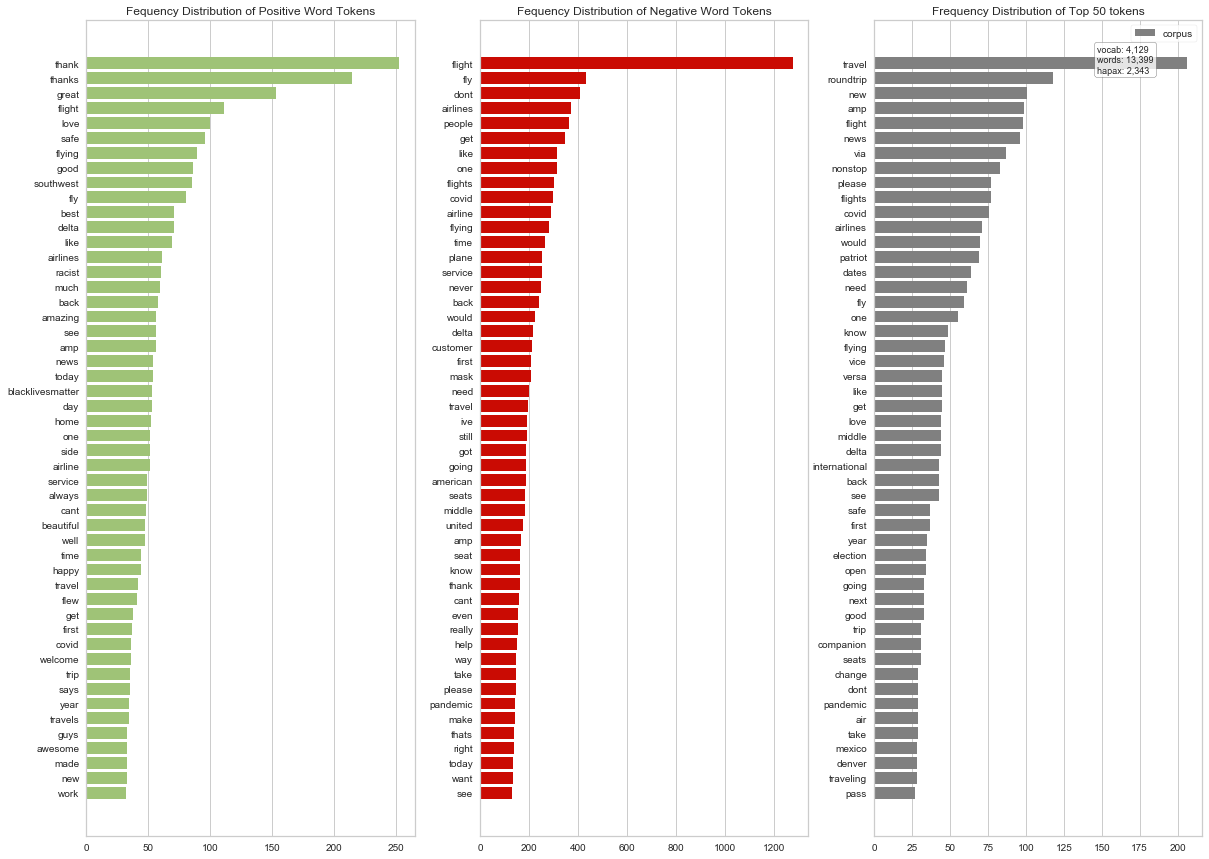

In [25]:
word_frequency_graph(AirlineResultsDF[['tweet','calculated_sentiment']])

### Further Analysis

In [26]:
AirlineResultsDF['calculated_sentiment'] = AirlineResultsDF["calculated_sentiment"].map({
    "positive": 1,
    "neutral": 0,
    "negative": -1
})

#print(AirlineResultsDF)

print(AirlineResultsDF.groupby('airline').calculated_sentiment.mean())


#plt.title('American Airlines')
#Results = Results.sort_values(by = 'calculated sentiment')
# read results to csv 
AirlineResultsDF.to_csv("Airline.csv")

airline
American    -0.647931
Delta       -0.472841
Southwest   -0.450047
United      -0.452494
Name: calculated_sentiment, dtype: float64


Sentiment   American     Delta  Southwest    United
day                                                
2020-11-08       NaN       NaN  -0.465753       NaN
2020-11-09       NaN       NaN  -0.463768       NaN
2020-11-10       NaN -0.471545  -0.558511       NaN
2020-11-11 -0.591270 -0.513274  -1.000000 -0.417840
2020-11-12 -0.660526 -0.579545   1.000000 -0.466667
2020-11-13 -0.593220  0.037037  -0.412639 -0.421875
2020-11-14 -0.694467 -0.438127  -0.484099 -0.338912
2020-11-15 -0.607143 -0.464286  -0.368421 -0.341463
2020-11-16 -0.619565  0.777778  -0.448052 -0.555921
2020-11-17 -0.142857  0.000000  -0.355705 -0.481013
2020-11-18 -0.647510 -0.486891  -0.462428 -0.489362
2020-11-19 -0.671598 -0.426523  -0.536443 -0.512894
2020-11-20 -0.621429 -0.571429  -0.449275 -0.633333
2020-11-21 -0.590909 -0.524540  -0.422222 -0.369748


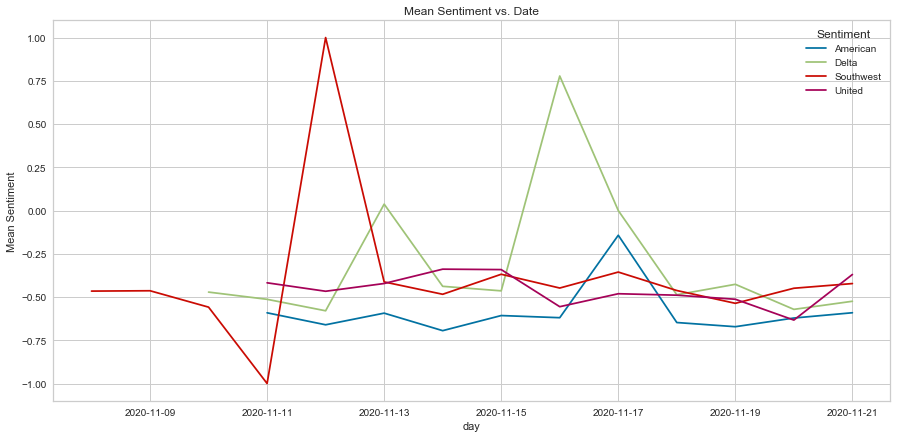

In [27]:
#print(AirlineResultsDF)
#plt.plot(AirlineResultsDF.groupby(["date"]),
#avg_lifeExp_by_cont_yr = AirlineResultsDF.groupby(['','continent'])['lifeExp'].mean()
     
AirlineResultsDF['date'] = pd.to_datetime(AirlineResultsDF['date'])
AirlineResultsDF['day'] = AirlineResultsDF["date"].dt.date

AirlineResultsDF
    

#blah = AirlineResultsDF.groupby(['day','airline']).calculated_sentiment


df = AirlineResultsDF.groupby(['day','airline']).calculated_sentiment.mean()


# prepare dataframe
#df = pd.read_csv('gapminder.tsv', sep='\t')
#df = df.groupby(['year','continent']).lifeExp.mean()

# unstack the `continent` index, to place it as columns
df = df.unstack(level='airline')

# The name of columns will become the name of legend when using dataframe plot
df.columns.name = 'Sentiment'

print(df)
# Now, we have a 2d talbe, 1st column become to X
# and other columns become to Y
# In [14]: df.head()
# Out[14]:
# Life Expectation     Africa  Americas       Asia     Europe  Oceania
# year
# 1952              39.135500  53.27984  46.314394  64.408500   69.255
# 1957              41.266346  55.96028  49.318544  66.703067   70.295
# 1962              43.319442  58.39876  51.563223  68.539233   71.085
# 1967              45.334538  60.41092  54.663640  69.737600   71.310
# 1972              47.450942  62.39492  57.319269  70.775033   71.910

# matplotlib operations
# Here we use dataframe plot function
# You could also use raw matplotlib plot one column each to do fine control
# Please polish the figure with more configurations
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Mean Sentiment vs. Date')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment')
df.plot(ax=ax);


## Section 3: Broad Market Sentiment Analysis

<a id='ExtractingMarket'></a>
### Extracting Data

In [28]:
# read the data from csv files
StockDF = pd.read_csv('TwitterStockData.csv')
SentimentDF = pd.read_csv('tweet_sentiment.csv')

# declare start and end date for financial data
start = datetime.datetime(2018,7,17)
end = datetime.datetime(2018,10,25)

# read S&P500 data for declared dates
SPY500 = web.DataReader('SPY', 'yahoo', start, end)
BTC = web.DataReader('BTC-USD', 'yahoo', start, end)

StockDF.head()


,text,timestamp,source,symbols,company_names,url,verified
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE


In [29]:
SentimentDF.head()

,cleaned_tweets,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1


In [30]:
SPY500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-17,280.910004,278.410004,278.470001,280.470001,52315500.0,268.572174
2018-07-18,281.179993,280.059998,280.559998,281.059998,44593500.0,269.137207
2018-07-19,280.739990,279.459991,280.309998,280.000000,61412100.0,268.122101
2018-07-20,280.480011,279.500000,279.769989,279.679993,82337700.0,267.815704
2018-07-23,280.429993,279.059998,279.450012,280.200012,47047600.0,268.313629


<a id='TidyingMarket'></a>
## Tidying Data

> The data we have used here was conveniently formatted in a way that did not require much altering. The data from Kaggle contained two separate CSV files. One for tweet information, and another for sentiment scores for cleaned tweets (a cleaned tweet omits unimportant words). Since sentiment scores are different from tweet information, this is exactly how we hoped the tables would be formatted. We can combine the two tables based on the indexes, as we do below:

In [31]:
# merge the two data frames (tweet info and tweet sentiment) - inner join based on index
StockSentimentDF = StockDF.merge(SentimentDF, how='inner', left_index = True, right_index=True)

<a id='ScrapingMarket'></a>
## Scrapping Additional Data 
>We wanted to use additional data so we scrapped data using the Python Yahoo! Finance library. This allows us to add useful info such as stock price movements (in the days following the tweet), tweet date as a datetime object, and the stock's sector. Using Yahoo Finance to scrape is extremely time-intensive, so we ran it on small subsets of our data and appended the results to a CSV file stored in local storage. This way we can read a CSV file in local storage instead of repeatedly scraping. To demonstrate the web scraping, we left the following example using the first ten entities:


In [32]:
StockSentimentDF = StockSentimentDF.head(10)

def getStockData(symbol, date):
        if not "-" in symbol:
            t = yf.download(symbol, start=date, end=date + datetime.timedelta(days=1))
            if t.size > 0:
                perc_change = (t["Open"].iloc[0] - t["Close"].iloc[0] ) / t["Open"].iloc[0]  * 100
                return perc_change
            return None
        else:
            return None
        
def getSector(symbol):
    try:
        ticker = yf.Ticker(symbol)
        c = ticker.info['sector']
        return c
    except:
        return None
    
def tweetDate(timestamp):
    t = datetime.datetime.strptime(timestamp, "%a %b %d %H:%M:%S +0000 %Y")
    return t.date()

StockSentimentDF["date"] = StockSentimentDF.apply(lambda row: tweetDate(row["timestamp"]), axis = 1)

StockSentimentDF["perc_change"] = StockSentimentDF.apply(lambda row: getStockData(row["symbols"], row["date"]), axis = 1)
StockSentimentDF["NextDay_perc_change"] = StockSentimentDF.apply(lambda row: getStockData(row["symbols"], row["date"] + datetime.timedelta(days=1)), axis = 1)
StockSentimentDF["sector"] = StockSentimentDF.apply(lambda row: getSector(row["symbols"]), axis = 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HRS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*****

>Note: Many of the observations will return 'failed to download' because most of our data is from 2018 and many ticker symbols have changed or been delisted.

<br>

Our data table now appears in the following format:

In [33]:
StockSentimentDF.head()

,text,timestamp,source,symbols,company_names,url,verified,cleaned_tweets,sentiment,date,perc_change,NextDay_perc_change,sector
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE,video offic mind busi david solomon tell gs in...,0,2018-07-18,0.473440,0.640386,Financial Services
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE,price lumber lb f sinc hit ytd high maci turna...,0,2018-07-18,-1.425888,-3.096052,Consumer Cyclical
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE,say american dream dead,-1,2018-07-18,-0.859863,1.912574,Financial Services
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE,barri silbert extrem optimist bitcoin predict ...,1,2018-07-18,NaN,NaN,None
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE,satellit avoid attack space junk circl earth paid,-1,2018-07-18,0.307443,-0.082639,Technology


In [34]:
# read the data we have already scraped and saved locally
StockSentimentDF = pd.read_csv('WebScrapedStockData.csv')
StockSentimentDF['date'] = pd.to_datetime(StockSentimentDF['date']) #change date column to datetime object

<a id='ExploratoryMarket'></a>
## Exploratory Data Analysis

### Stock Sectors
> First, we looked at the sector of stocks mentioned in our Twitter data.  Our distribution contains several different sectors, which means that users on Twitter are interested in a very diverse set of stocks.

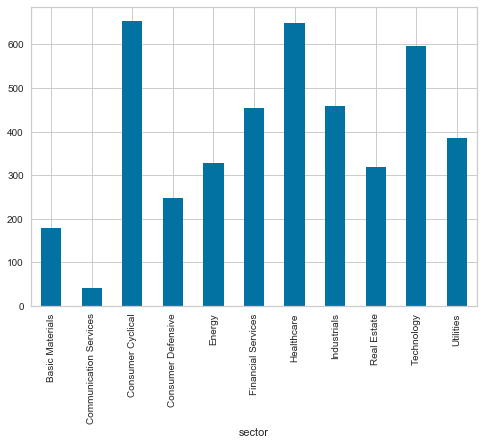

In [35]:
e = StockSentimentDF.groupby(['sector']).count()
e["text"].plot.bar()

# look at sector etf data
SPY500 = web.DataReader('SPY', 'yahoo', start, end)
BTC = web.DataReader('BTC-USD', 'yahoo', start, end)

<a id='SectorgMarket'></a>
## Gauging Sector Sentiment
>We can attempt to gauge if tweet sentiment grouped by sector helps us determine trends in various sectors. The ETF's we will use to measure performance are the following:

>- Energy: XLE
>- Materials: XLB
>- Industrials: XLI
>- Consumer Discretionary: XLY
>- Consumer Staples: XLP
>- Health Care: XLV
>- Financials: XLF
>- Information Technology: SMH
>- Telecommunication Services: XTL
>- Utilities: XLU
.- Real Estate: IYR 

First, we determine what our data says about various sectors by summing the net sentiment analysis for each sector:

sector
Basic Materials            73
Communication Services      8
Consumer Cyclical         141
Consumer Defensive         58
Energy                     64
Financial Services         85
Healthcare                115
Industrials               102
Real Estate                63
Technology                110
Utilities                  37
Name: sentiment, dtype: int64


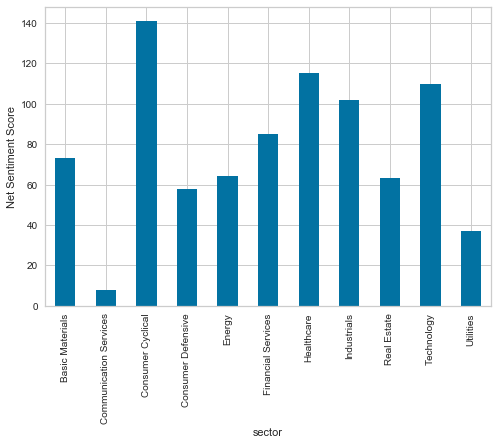

In [36]:
# bar plot of the net sentiment value for each sector
StockSentimentDF.groupby(['sector']).sentiment.sum().plot.bar();
plt.ylabel('Net Sentiment Score')

# print total sentiment score table - Notice they are all positive
print(StockSentimentDF.groupby(['sector']).sentiment.sum())

Note: Notice how all the sectors have a net positive sentiment score. This might mean a couple of things:
>1. The market is healthy across most sectors at this time (possibly some healthier than others)
>2. The algorithm used to calculate sentiment is not accurate (biased in thinking tweets are positive)
>3. People generally tweet more about positive things than negative things

>This warrants further investigation for the final deliverable.

We know from the previous section that the distribution of tweets by sector is not evenly distributed (i.e. there are more than 600 tweets about healthcare and consumer cyclical companies and less than 100 tweets regarding communication services). Thus, it is probably better to look at the mean sentiment analysis by each sector:

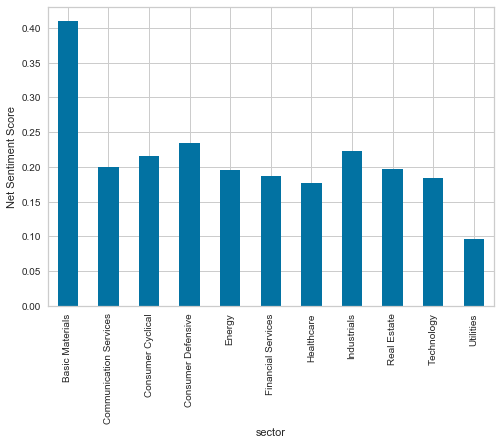

In [37]:
StockSentimentDF.groupby(['sector']).sentiment.mean().plot.bar();
plt.ylabel('Net Sentiment Score')
plt.show();

Now we record info on the specified ETF's that relate to each sector:

In [38]:
# Common ETF's we will use to compare against tweet sentiment grouped by financial sector
ETFs = ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'SMH', 'XTL', 'XLU', 'IYR']

# for each etf, grab the data for the desired dates
for etf in ETFs:
    locals()[etf] = web.DataReader(etf, 'yahoo', start, end) # save price information to local variable with name of ETF

### Comparing Sector ETF Returns
> We saw in the previous section that the Consumer Cyclical and Industrial sectors seem to have a positive sentiment on Twitter. Communications and Utilities appear to be lagging in terms of net tweet sentiment (more neutral). We first calculate the returns for these sectors using the ETF's described above, and then we compare the distribution of these sectors returns (daily percent change) using a histogram and a kernel density plot.


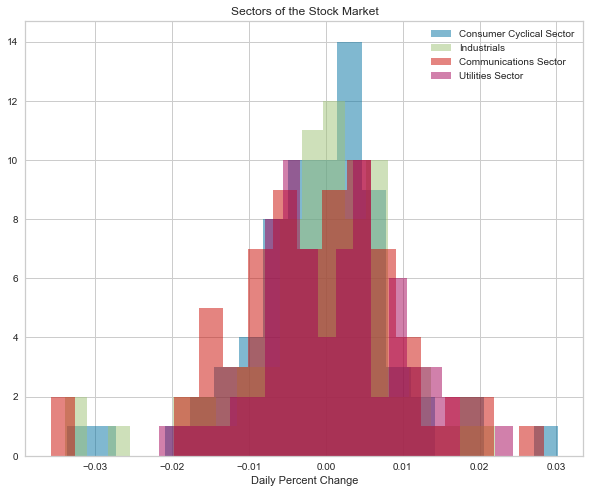

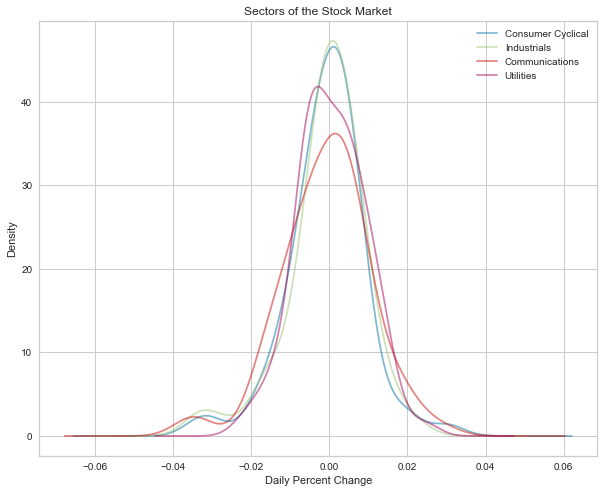

In [39]:
# Calculate returns for positive sentiment sectors
XLY['Returns'] = (XLY['Close'] / XLY['Close'].shift(1)) - 1 # Consumer Cyclical
XLI['Returns'] = (XLI['Close'] / XLI['Close'].shift(1)) - 1 # Industrials

# Calculate returns for the more neutral sentiment sectors
XTL['Returns'] = (XTL['Close'] / XTL['Close'].shift(1)) - 1 # Communications
XLU['Returns'] = (XLU['Close'] / XLU['Close'].shift(1)) - 1 # Utilities

# alternative method: XLU['Returns'] = XLU['Close'].pct_change(1)

XLY['Returns'].hist(bins=20, label = 'Consumer Cyclical Sector', figsize = (10,8), alpha = 0.5)
XLI['Returns'].hist(bins=20, label = 'Industrials', figsize = (10,8), alpha = 0.5)
XTL['Returns'].hist(bins=20, label = 'Communications Sector', figsize = (10,8), alpha = 0.5)
XLU['Returns'].hist(bins=20, label = 'Utilities Sector', figsize = (10,8), alpha = 0.5)
plt.xlabel('Daily Percent Change')
plt.title('Sectors of the Stock Market')
plt.legend()
plt.show();

# simliar method for kernal density plot
XLY['Returns'].plot(kind = 'kde', label = 'Consumer Cyclical', figsize = (10,8), alpha = 0.5)
XLI['Returns'].plot(kind = 'kde', label = 'Industrials', figsize = (10,8), alpha = 0.5)
XTL['Returns'].plot(kind = 'kde', label = 'Communications', figsize = (10,8), alpha = 0.5)
XLU['Returns'].plot(kind = 'kde', label = 'Utilities', figsize = (10,8), alpha = 0.5)
plt.xlabel('Daily Percent Change')
plt.title('Sectors of the Stock Market')
plt.legend()
plt.show();

This shows us that the Consumer Cyclical and Industrial ETF's had less volatility. We can also see that Utilities did not perform well over this period because the peak density is a negative percent change. The Communications ETF was more volatile than the others over this period (we can tell because it is a wider distribution).

### Number of stock tweets per day
> Next, we were interested in the number of tweets any given stock gets in one day.  Our set is rather limited, and the most popular symbol-date pairings are shown below.  

In [40]:
b = StockSentimentDF.groupby(['symbols', 'date']).count()
b = b.sort_values("text", ascending = False).head() # top 5 most commonly tweeted stocks on any given day
selection = b['text']
print(selection) # print the 5 most popular symbol-date pairings

symbols  date      
MHK      2018-07-11    33
IP       2018-07-10    33
ABC      2018-07-12    30
DLPH     2018-07-09    29
NBL      2018-07-12    29
Name: text, dtype: int64


<a id='CorrelationMarket'></a>
### Correlation

### Plotting Price Percent Change vs. Average Sentiment

> Here, we take the average sentiment from Twitter regarding a particular stock on a particular date, and plot it against the percent change on that day.  We expect to see a positive correlation between the two because if a stock performs well on a given day, we expect general optimism throughout Tweets on that day. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation:  -0.007066127090598155


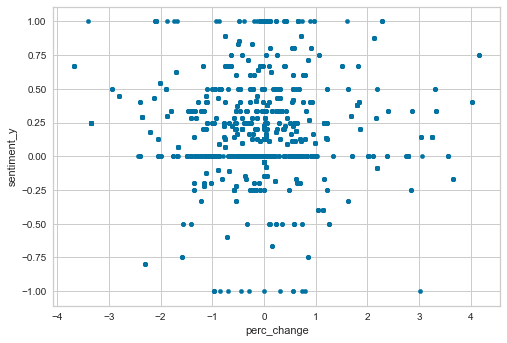

In [41]:
m = StockSentimentDF.groupby(['symbols', 'date']).mean()
t = StockSentimentDF.merge(m, on=["symbols", "perc_change"])
t.plot.scatter(x="perc_change", y="sentiment_y")
print("Correlation: ", t["perc_change"].corr(t["sentiment_y"]))

### Plotting Next-Day Price Percent Change vs. Average Sentiment
> This is similar to the plot above.  However, instead of looking at the price percent change of the day of the tweet, we are now looking at the price percent change of the next day.  In essence, a positive correlation means that optimistic tweets might have optimistic effects on a stock on the following day.  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation:  0.0391721642623727


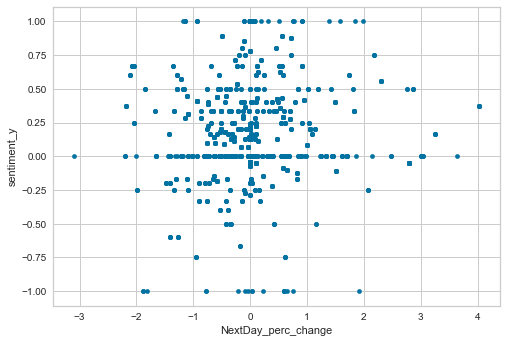

In [42]:
m = StockSentimentDF.groupby(['symbols', 'date']).mean()
t = StockSentimentDF.merge(m, on=["symbols", "NextDay_perc_change"])
t.plot.scatter(x="NextDay_perc_change", y="sentiment_y")
print("Correlation: ", t["NextDay_perc_change"].corr(t["sentiment_y"]))

<a id='BTCMarket'></a>
## Overall Market Sentiment vs Bitcoin Sentiment

>We also wanted to check to see if Twitter sentiment could gauge whether Bitcoin or the overall market (we'll use the S&P500 to measure this) is more likely to rise. We first create two bar plots to compare Twitter's bitcoin sentiment and Twitter's market sentiment (Non-cryptocurrencies).

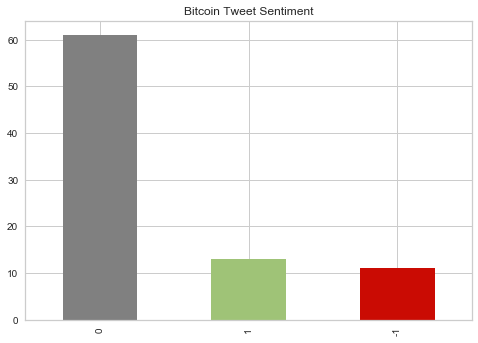

In [43]:
# read the data from csv files
StockDF = pd.read_csv('TwitterStockData.csv')
SentimentDF = pd.read_csv('tweet_sentiment.csv')
                          
# merge the two data frames (tweet info and tweet sentiment) - inner join based on index
StockSentimentDF = StockDF.merge(SentimentDF, how='inner', left_index = True, right_index=True)

# create a bar graph displaying the number of neutral, positive and negative BTC tweets 
colors = ['grey','g','r']
StockSentimentDF[StockSentimentDF.symbols == 'BTC'].sentiment.value_counts().plot.bar(color = colors, title = "Bitcoin Tweet Sentiment");

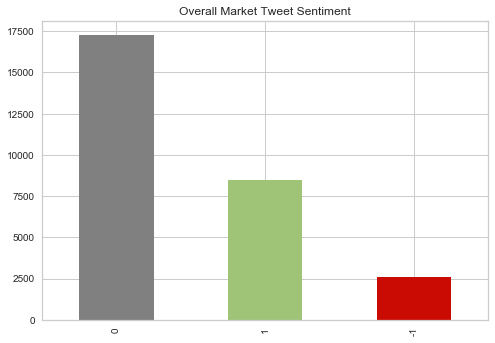

In [44]:
# create a bar graph displaying the number of neutral, positive and negative non-BTC tweets (Overall Market)
StockSentimentDF[StockSentimentDF.symbols != 'BTC'].sentiment.value_counts().plot.bar(color = colors, title = "Overall Market Tweet Sentiment");

>The first graph would suggest that Bitcoin sentiment is somewhat neutral (there is no real consensus), but the second graph suggests Twitter has a more optimistic view of the overall market.

<br>

Let's see how Bitcoin and the overall market did during the time our data was collected:

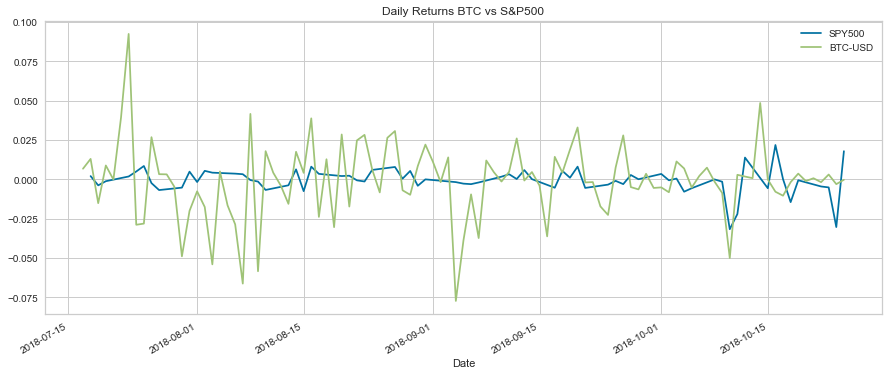

In [45]:
# calculate daily percent change in new column 'returns'
SPY500['returns'] = SPY500['Close'].pct_change(1)
BTC['returns'] = BTC['Close'].pct_change(1)

# plot the daily returns for BTC and SPY500
SPY500['returns'].plot(kind = 'line', title = "Daily Returns BTC vs S&P500", label = 'SPY500', figsize = (15,6))
BTC['returns'].plot(kind = 'line', title = "Daily Returns BTC vs S&P500", label = 'BTC-USD', figsize = (15,6))
plt.legend()
plt.show()

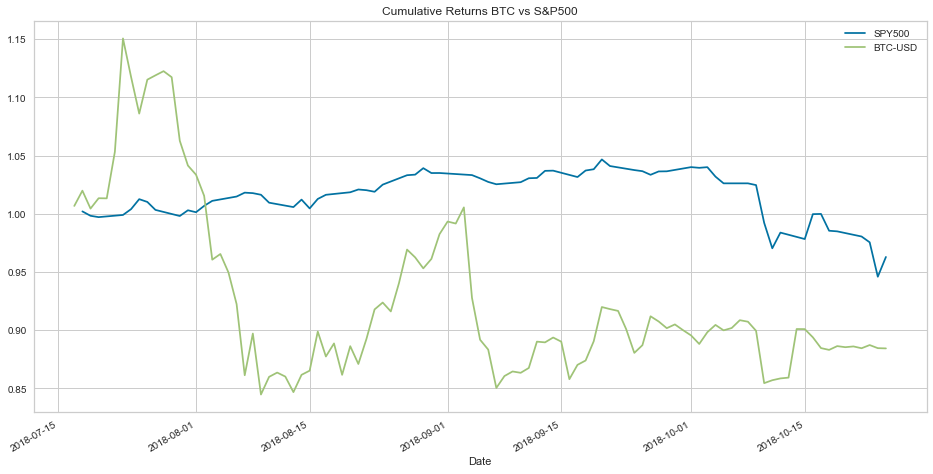

In [46]:
# calculate cumulative returns in a new column ''daily_cumulative_return'
SPY500['daily_cumulative_return'] = ( 1 + SPY500['returns'] ).cumprod()
BTC['daily_cumulative_return'] = ( 1 + BTC['returns'] ).cumprod()

# plot the cumulative returns for BTC and SPY500
SPY500['daily_cumulative_return'].plot(label='SPY500',figsize= (16,8))
BTC['daily_cumulative_return'].plot(label = 'BTC-USD', title = "Cumulative Returns BTC vs S&P500")
plt.legend();
plt.show()


>### Results
>While the overall market (the SPY500) did outperform Bitcoin during the timeframe our data was collected, neither performed particularly well. The first graph shows us that bitcoin is much more volatile over this period and the second graph shows us that both investments would result in a net loss over this time period.

<a id='FinalThoughtsMarket'></a>
## Final Thoughts

There are a lot of factors when it comes to pricing equities, and so it has been difficult to determine whether there is any correlation between our tweet sentiment data and stock prices. We worry about the accuracy of the sentiment analysis data we collected - sentiment analysis is a tricky thing to do with a high degree of accuracy. We will continue to scrape more data because we think our project is currently limited by the amount of data resources we have been able to find. We also would like to use the Granger causality test to gauge the likelihood that our data has any relationship with stock market trends.